In [1]:
import mne
from tqdm.notebook import tqdm, trange
import numpy as np
import os
import pandas as pd
import load_match_save

# 1. mne.create_info
- ch_names, sfreq 설정

In [2]:
ch_names = ['C3']
sfreq = 500
ch_types = ['eeg']

In [3]:
temp_info = mne.create_info(ch_names, sfreq, ch_types, verbose=None)
temp_info

<Info | 7 non-empty values
 bads: []
 ch_names: C3
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 500.0 Hz
>

# 2. read test_eeg.txt 

In [4]:
path_test_eeg = 'test_VD012_C3.txt'
with open(path_test_eeg, 'r') as f:
    lines = f.readlines() # Read txt file
    lines = lines[5:] # include only valid information which contains the signal values

In [26]:
new_lines = []
for line in tqdm(lines, desc='Extract eeg values ... '):
    temp_value = line.strip().split()[1]
#     if temp_value == '-1.#QNAN':
#         temp_value = 0
    c.append(temp_value)

print("Convert valuse in string into values as numpy array of float")
# data_np = np.array(new_lines, dtype=float)


Extract eeg values ... :   0%|          | 0/22615618 [00:00<?, ?it/s]

Convert valuse in string into values as numpy array of float


In [22]:
reshaped_data_np = data_np.reshape(1,len(data_np))
print(reshaped_data_np.shape)
reshaped_data_np

(1, 22615618)


array([[ 0.00000e+00, -9.20000e-08,  3.22000e-06, ..., -2.32024e-04,
        -2.32576e-04, -2.40764e-04]])

# 3. Raw Array 생성

In [7]:
raw = mne.io.RawArray(reshaped_data_np, temp_info)
raw

Creating RawArray with float64 data, n_channels=1, n_times=22615618
    Range : 0 ... 22615617 =      0.000 ... 45231.234 secs
Ready.


<RawArray | 1 x 22615618 (45231.2 s), ~172.5 MB, data loaded>

# 4. export as edf file

In [8]:
save_as  = 'VD012\\Traces.edf'
mne.export.export_raw(save_as, raw, fmt='edf')

C:\Users\CYS\AppData\Local\Temp\ipykernel_14128\254321978.py:2: RuntimeWarning: EDF format requires equal-length data blocks, so 0.764 seconds of zeros were appended to all channels when writing the final block.
  mne.export.export_raw(save_as, raw, fmt='edf')


# 5. time matching

In [9]:
meas_time_df = pd.read_csv('D:\\USC\\code_mine\\Exploration_for_VD_dataset\\meas_time_edf_hypno.csv', index_col=0)
meas_time_df.head()

,hypno_start,hypno_end,edf_start,edf_duration,edf_end,start_mismatch,end_mismatch
LE004,0:31:00,5:52:00,0:17:47,5:34:26,5:52:13,0,0
LE010,0:24:30,6:36:30,0:16:31,6:20:54,6:37:25,0,0
LE011,0:13:00,6:39:00,0:10:39,6:36:12,6:46:51,0,0
LE014,0:24:30,6:08:00,0:18:44,5:49:56,6:08:40,0,0
LE019,0:32:00,6:18:30,0:12:15,6:07:08,6:19:23,0,0


In [10]:
path_subjects_edf = 'D:\\USC\\code_mine\\mk_new_edf'
subject_edf = 'VD012'
path_save = 'D:\\USC\\code_mine\\mk_new_edf\\edf_matched'
load_match_save.for_vd(path_subjects_edf, subject_edf, meas_time_df, path_save)

This is algorithm for VD dataset !
-- D:\USC\code_mine\mk_new_edf\VD012\Traces.edf
[]
-- Available Channels: ['C3']
hypno_start  hypno_end  edf_start  edf_end
0:06:30   6:30:00   17:56:32   6:30:24
-- Edf time after mathcing: 0:06:00  6:30:01
-- ground_truth time: 0:06:30  6:30:00


D:\USC\code_mine\mk_new_edf\load_match_save.py:124: RuntimeWarning: EDF format requires equal-length data blocks, so 0.998 seconds of zeros were appended to all channels when writing the final block.
  mne.export.export_raw(save_as, raw, fmt='edf')


In [11]:
# matching 된 edf 확인

now_edf = 'edf_matched\\VD012.edf'
raw = mne.io.read_raw_edf(now_edf, preload=True, verbose=False)
raw

[]


<RawEDF | VD012.edf, 1 x 11520500 (23041.0 s), ~87.9 MB, data loaded>

# 6. Automatic Staging Using YASA

<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

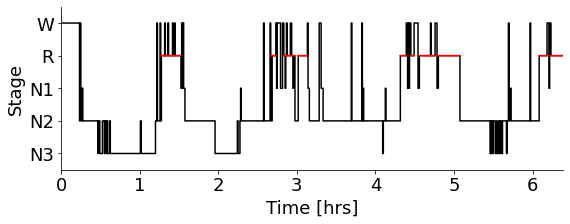

In [16]:
import yasa
import seaborn as sns
sls = yasa.SleepStaging(raw, eeg_name='C3')
hypno_pred = sls.predict()
hypno_pred = yasa.hypno_str_to_int(hypno_pred)
prob_pred = sls.predict_proba()

C:\Users\CYS\AppData\Local\Temp\ipykernel_14128\2017726441.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ground_csv = pd.read_csv('VD012.csv', squeeze=True)


<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

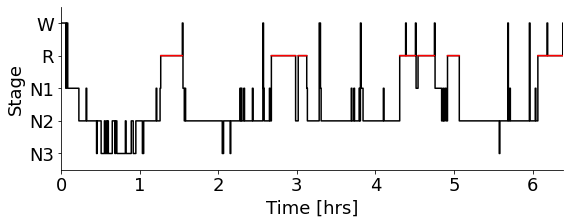

In [21]:
ground_csv = pd.read_csv('VD012.csv', squeeze=True)
yasa.plot_hypnogram(ground_csv)

<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

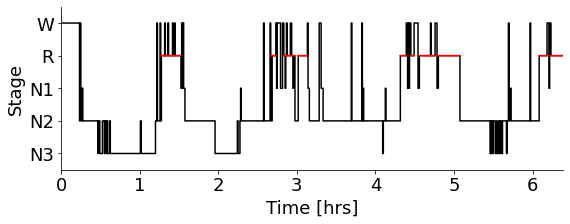

In [17]:
yasa.plot_hypnogram(hypno_pred)

<AxesSubplot:xlabel='epoch'>

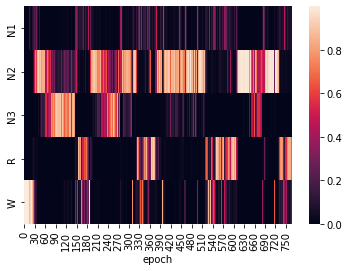

In [15]:
sns.heatmap(prob_pred.transpose())